In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Load Dataset
data_url = "wdbc.data"
data = pd.read_csv(data_url, header=None)

In [3]:
# Dataset preprocessing

data.columns = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1, 31)]
data.drop("ID", axis=1, inplace=True)

# Transform Diagnosis into binary target variable
data["Diagnosis"] = data["Diagnosis"].map({"M": 1, "B": 0})

# Features and target(Retain all numerical features for analysis)
X = data.drop("Diagnosis", axis=1)
y = data["Diagnosis"]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Scale data(Normalize features to [0, 1] for SVM to handle distance-based calculations better)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# Support Vector Machine (SVM)
svm_params = {'C': [0.1, 1, 10], 'gamma': [
    0.001, 0.01, 0.1], 'kernel': ['rbf']}
svm_model = SVC(probability=True, random_state=42)
svm_grid = GridSearchCV(svm_model, svm_params, cv=5, scoring='roc_auc')
svm_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1],
                         'kernel': ['rbf']},
             scoring='roc_auc')

In [5]:

# Random Forest
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='roc_auc')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [6]:
# Evaluate Models
svm_best = svm_grid.best_estimator_
rf_best = rf_grid.best_estimator_

svm_preds = svm_best.predict(X_test_scaled)
svm_probs = svm_best.predict_proba(X_test_scaled)[:, 1]

rf_preds = rf_best.predict(X_test)
rf_probs = rf_best.predict_proba(X_test)[:, 1]

# Print Evaluation Metrics
print("SVM Classification Report:\n", classification_report(y_test, svm_preds))
print("SVM ROC-AUC:", roc_auc_score(y_test, svm_probs))

print("Random Forest Classification Report:\n",
      classification_report(y_test, rf_preds))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, rf_probs))

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

SVM ROC-AUC: 0.9970520799213889
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Random Forest ROC-AUC: 0.9952505732066819


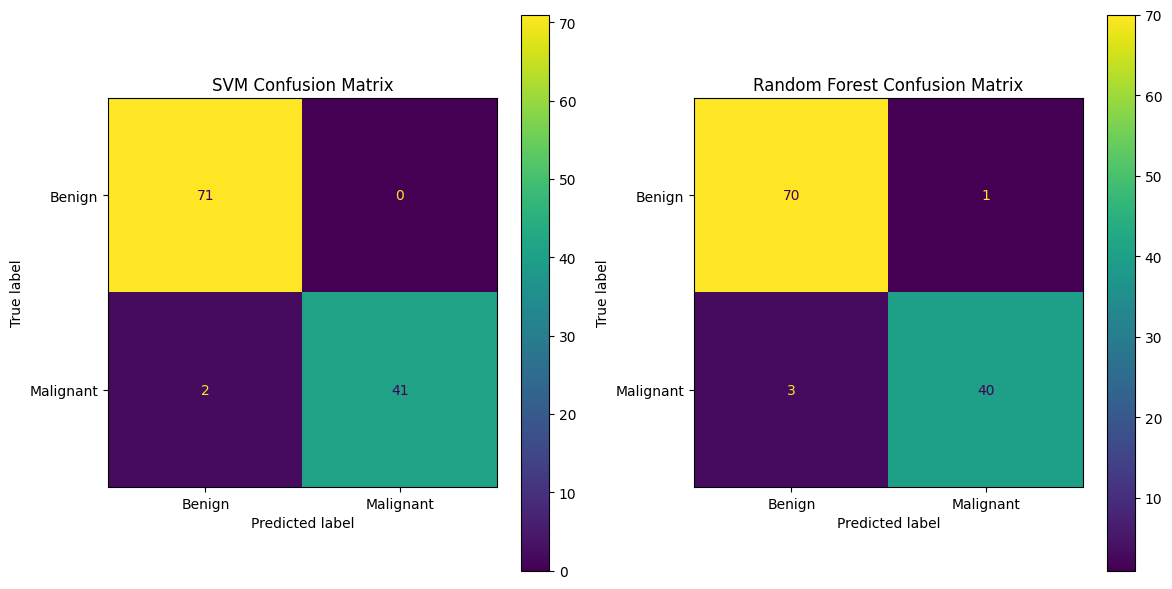

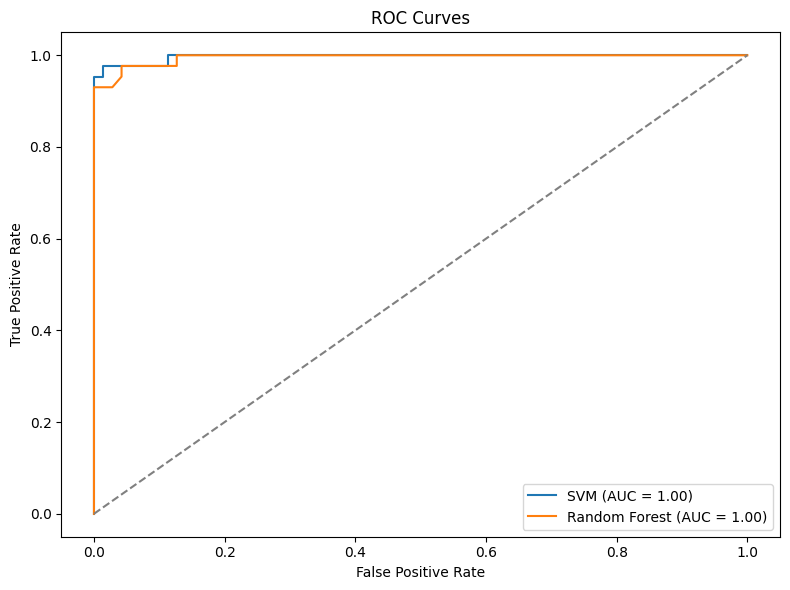

In [7]:
# Confusion Matrix Visualization
from sklearn.metrics import roc_curve, auc
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# SVM Confusion Matrix
svm_cm = confusion_matrix(y_test, svm_preds)
ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=[
                       "Benign", "Malignant"]).plot(ax=axes[0])
axes[0].set_title("SVM Confusion Matrix")

# Random Forest Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_preds)
ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=[
                       "Benign", "Malignant"]).plot(ax=axes[1])
axes[1].set_title("Random Forest Confusion Matrix")

plt.tight_layout()
plt.show()

# Additional Visualization - ROC Curves

fig, ax = plt.subplots(figsize=(8, 6))

# SVM ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
roc_auc_svm = auc(fpr_svm, tpr_svm)
ax.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.2f})")

# Random Forest ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)
ax.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")

# Plot settings
ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves")
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [8]:
# Feature Importance from Random Forest
rf_feature_importances = rf_best.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(
    {'Feature': feature_names, 'Importance': rf_feature_importances})
feature_importances = feature_importances.sort_values(
    by='Importance', ascending=False)
print("Random Forest Feature Importances:\n", feature_importances.head(10))

Random Forest Feature Importances:
        Feature  Importance
23  Feature_24    0.153892
27  Feature_28    0.144663
7    Feature_8    0.106210
20  Feature_21    0.077987
6    Feature_7    0.068001
22  Feature_23    0.067115
2    Feature_3    0.053270
0    Feature_1    0.048703
3    Feature_4    0.047555
26  Feature_27    0.031802
